## Least Cost Pipeline Construction
This notebook imports the cost distance stack generated by `Create-Cost-Stack.ipynb` and a pipeline raster to compute a least cost "feeder" pipeline configuration. The workflow for this process is:
1. Import the stack of cost distance layers (one for each biogas source): $arr\_stack$.
1. Import the pipeline raster, setting non-pipeline cells to NaN: $arr\_pipeline$.
1. Determine which pixel among the pipeline pixels has the least cost among all farm cost distances rasters. This will serve as the location of the connection point to the existing pipeline: $C_0$.
1. Determine which farm is the source of this minimum point, done by finding which layer (in the stack of cost distance rasters) has the minimum value at that location. This represents the least cost biogas source: $F_0$.
1. Compute the least cost path connecting that farm ($F_0$) to the connection point ($C_0$): $LCP_0$.
1. Update the connection point layer ($C_0$) to include the least cost path ($LCP_0$): $Pipes_0$.
1. Remove the layer associated with $F_0$ from the stack of cost distance rasters ($arr\_CDsk$) and repeat steps 4-7:
    * Locate the minimim value among all remaining cost distance rasters to cells in the Pipes layer ($C_i$)...
    * Idenfity the source farm associated with this minimum ($F_i$)...
    * Compute the least cost path from from $F_i$ to $C_i$...
    * Update the connection point layer ($Pipes_{i+1}$)...

In [1]:
#Import packages
import numpy as np
import pandas as pd
from skimage import graph
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read the cost and cost distance stacks
arrCosts = np.load('../data/DuplinCostStack.npy')
arrStack = np.load('../data/DuplinStack.npy')

In [3]:
#Read in the pipeline raster
ds =  gdal.Open('../data/processed/duplin_pipe_diameter.tif')
#Get the raster projection
ds_prj = ds.GetProjection()
ds_WKT = 'PROJCS["North_America_Equidistant_Conic",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Equidistant_Conic"],PARAMETER["False_Easting",0],PARAMETER["False_Northing",0],PARAMETER["central_meridian",-96],PARAMETER["Standard_Parallel_1",20],PARAMETER["Standard_Parallel_2",60],PARAMETER["latitude_of_origin",40],UNIT["Meter",1]]'
#Get raster attributes (used in MCP analysis)
llx, x_size, x_angle, lly, y_angle, y_size = ds.GetGeoTransform()
#Extract Band1 as the cost array; divide by 100 to scale as a percentage
arrPipesAll = np.array(ds.GetRasterBand(1).ReadAsArray())
#Convert all pipe pixels to 1, others to -1
arrPipesAll[arrPipesAll >= 0] = 1
arrPipesAll[arrPipesAll < 0] = -1
#Convert to a masked array (ignoring all values < 0, which are NoData)
arrPipes = np.ma.masked_array(arrPipesAll, mask=arrPipesAll < 0)

In [4]:
#Read in biogas sources (example: Duplin Co)
dfBG =  pd.read_excel('../data/DuplinCountySwineFarmEconomics.xlsx',
                         sheet_name='Duplin County Swine Farm Master').iloc[:,[11,12,17,19,22]]
#Sort values in ascending order by cost to pipe
dfBG.sort_values(by='TEST ($/mi-MMBtu @15y)',ascending=True,inplace=True)
#Set the master index as the value of indices
master_index = dfBG.index.tolist()

## Functions

In [5]:
def getMin(array_stack,array_mask,verbose=False):
    '''Returns the layer and row/col index of the pixel in a stack of layers containing the 
       overall minimum value found among cells within the supplied mask array.
    
    Arguments:
     array_stack (3d array): Stack of cost distance layers from each biogas source
     array_mask (2d array): Layer of pixels from which min values should be returned
     verbose (Boolean): Set to true to display processing messages
    
    Returns (tuple):
     [1] (integer) Index of the layer in the array_stack containing the minimum values
     [2] (tuple) Row/column coordinates of the pixel containing the minimum value.
     [3] (float) The vost value at the location
    
    '''
    #Reduce the stack of cost distance layers to a layer of the minimum value at each location
    arrMin = np.amin(array_stack,axis=0)
    #Mask the values so only pipeline pixels are kept
    arrMin_masked = np.ma.masked_array(arrMin, mask=array_mask != 1)
    #Find the min value of the pipeline pixels
    minValue = np.amin(arrMin_masked)
    #Determine the row and column where the min occurs
    rMin,cMin = np.where(arrMin_masked == minValue)
    #Extract values from value arrays
    rowMin = rMin[0];  colMin = cMin[0]
    #Find which layer has the min value at this location in the stack of layers
    layers = np.where(array_stack[:,rowMin,colMin] == minValue)[0]
    #if len(layers) > 1: layerIdx = layers[0]
    #else: layerIdx = [layers]
    layerIdx = layers[0]
    if verbose: print("Link to LCP row/col ({},{} (Layer:{}, Cost:{:.2f}))".format(rowMin,colMin,layerIdx,minValue))
    return(layerIdx,(rowMin,colMin),minValue)

In [6]:
def getSourceCoordinates(array_stack,layer_id,verbose=False):
    '''Returns the row and column index for a biogas source in the provided layer
    
    Args: 
     array_stack (3d array): Stack of cost distance layers from each biogas source
     layer_id (integer): Index value of the layer containing the biogas source
     verbose (Boolean): Set to true to display processing messages
    
    Returns (tuple): 
     The Row/column coordinates of the pixel containing the minimum 
     value in the layer, i.e., the biogas source.
    
    '''
    #Get the layer from the stack corresponding to the source
    arrSource = array_stack[layer_id]
    #Find the minimum of that layer
    minValue = np.amin(arrSource)
    #Get the row and columns corresponding to that value
    rFarm,cFarm = np.where(array_stack[layer_id,:,:]==minValue)
    #Convert value arrays to just values
    theRow = rFarm[0]; theCol = cFarm[0]
    if verbose: print("Source occurs at ({},{})".format(theRow,theCol))
    #Return coords as a tuple
    return(theRow,theCol)

In [7]:
def getLCP(array_costs,layer_id,source_coords,pipe_coords,x_size=500,y_size=500):
    '''Returns a least cost layer between biogas source and pipeline coordinates
       for a given layer using the cost surface for a specific biogase source among
       the stack of biogas cost surface layers. 
       
    Args:
     array_costs (3d array): Stack of cost rasters (not cost distance) for each source
     layer_id (integer): Index value of the layer containing the biogas source
     source_coords (tuple): Row/column of the pixel containing the biogas source (start of LCP)
     pipe_coords (tuple): Row/columns of the pipeline pixel to connect (end of LCP)
     x_size (integer): Pixel width, in units of the cost layers [default=500(m)]
     y_size (integer): Pixel height, in units of the cost layers [default=500(m)]
     
    Returns (2d array):
     A 2D array of 1s and 0s where 1s represent the least cost pathway between biogas
     source and the pipeline coordinate provided. 
    '''
    #Extract the cost surface for that farm
    arrCost = array_costs[layer_id,:,:]
    #Create the MCP graph object from the farm location
    lc_graph = graph.MCP_Geometric(arrCost, sampling=(x_size,y_size))
    #Compute the cost distance and traceback arrays
    cd_array,tb_array = lc_graph.find_costs(starts=([source_coords]))
    #Get the row/col indices of pixels in the LCP 
    lcp_indices = lc_graph.traceback(pipe_coords)
    #Convert collection of indices to a layer
    arr_LCP = np.zeros(arrCost.shape) #Create a layer of all NaNs
    for r,c in lcp_indices:                 #Loop through coordinates in traceback
        arr_LCP[r,c] = 1                     # ..set values to 1
    #Return the lcp array
    return(arr_LCP,lcp_indices)

In [8]:
def coordsToline(coord_list,ll_x,ll_y,x_size,y_size):
    '''Convert a list of row/col coordinates to a line feature.
    
    Args: 
        coordList (list): collection of array coordinates
        ll_x (float): geographic x coordinate of lower left corner of array
        ll_y (float): geographic y coordinate of lower left corner of array
        x_size (float): pixel size in the x direction
        y_size (float): pixel size in the x direction
        
    Returns:
        Shapely linestring object
    
    '''
    #Import library
    from shapely.geometry import LineString
    #Initialize the list of geographic coordinates
    outCoords = []
    #Iterate through coordinates, georeference, and add to the list
    for row,col in coord_list:
        #Convert row and column indicies to geographic coordinates
        x = x_size * col + llx + (x_size/2)
        y = y_size * row + lly + (y_size/2)
        #Append to the list
        outCoords.append((x,y))
        
    #Construct a shapely linestring
    try:
        line = LineString(outCoords)
    except:
        return LineString((outCoords[0],outCoords[0]))
    
    #Return the line
    return line

## Main code, Part 1
1. Find the least costly point on the existing NG pipeline and the layer ID of the biogas source.
1. Identify the coordinates of that biogas source.
1. Construct the least cost path from source to pipeline.

In [9]:
#Get location of the connection point
layerID, pipeCoords, pipeCost = getMin(array_stack=arrStack,array_mask=arrPipes,verbose=True)
#Get the location of the source for that point
srcCoords = getSourceCoordinates(array_stack=arrStack,layer_id=layerID,verbose=True)
#Create the LCP array
arrLCP_first,coordList_first = getLCP(array_costs=arrCosts,layer_id=layerID,
                                      source_coords=srcCoords,pipe_coords=pipeCoords)
#Get the Biogas index value of the layer (and remove from list)
bgIndex = master_index.pop(layerID)

Link to LCP row/col (91,48 (Layer:0, Cost:2.54))
Source occurs at (114,63)


## Main code, Part 2
With the initial least cost path created, the following steps are to iterate through the remaining layers, finding the next least cost farm to connect, but this time connecting it to the least cost path deteremined above. This LCP is then added to the base LCP and the cycle continues...
1. Remove the layer corresponding to the least cost biogas source from the stack of cost distance layers.
1. Iterate through the remaining layers, and with each:
 1. Find the least costly source to connect among remaining layers, as well as the coordinates of the connection point.
 1. Find the coordinates of the corresponding biogas source.
 1. Construct the least cost path between the source and the identified connection point.
 1. Combine that least cost path with the existing least cost path.
 1. Remove the source's layer from the remaining stack of cost distance layers.


In [10]:
#Initialize lists of layer indices, costs, LCP arrays, and LCP lines
sourceIds = [bgIndex]    
pipeCosts = [pipeCost]
pipeArrays = [arrLCP_first * pipeCost]
pipeLines = [coordsToline(coordList_first,llx,lly,x_size,y_size)]

#Drop the original layer from the stacks and remove the index from the master_index
arrStack_next = np.delete(arrStack,layerID,axis=0)

#Copy the initial LCP
arrLCP = arrLCP_first.copy()
#Create a dataframe of the initial least cost pipeline
dfLCP = pd.DataFrame(arrLCP)   

#Loop through the remaining layers until all layers have been processed
remaining = arrStack_next.shape[0]
while arrStack_next.shape[0] > 0:
    #print(remaining,end=' ')
    #Get the layer containing the next cheapest source to the nearest pipe, and the location to connect
    layerID, pipeCoords, pipeCost = getMin(arrStack_next,arrLCP,verbose=False)
    #Get the location of the farm associated with that layer
    farmCoords = getSourceCoordinates(arrStack_next,layerID,verbose=False)
    #Extract the LCP from the farm to the pipe coordinate
    arrLCP_next,coordList_next = getLCP(arrCosts,layerID,farmCoords,pipeCoords)
    #Construct the lcp line feature
    lineString = coordsToline(coordList_next,llx,lly,x_size,y_size)
    pipeLines.append(lineString)
    #Add the pipe cost and least cost path arrays to their respective list
    bgIndex = master_index.pop(layerID)
    sourceIds.append(bgIndex)
    pipeCosts.append(pipeCost)
    pipeArrays.append(arrLCP_next * pipeCost) 
    #Update the pipe network array with the new LCP (max of binary arrays)
    arrLCP = np.maximum(arrLCP,arrLCP_next) 
    #Remove the processed layer from the stack
    arrStack_next1=np.delete(arrStack_next,layerID,axis=0)
    arrStack_next = arrStack_next1
    #Update the number of remaining stacks
    remaining = arrStack_next.shape[0]

In [11]:
#Construct a feature class of the lines
import geopandas as gpd
#Contruct a geodataframe: start with the list of pipeline linestrings
gf = gpd.GeoDataFrame(pipeLines,columns=['geometry'])
#Add the biogas source IDs costs
gf['Ids'] = sourceIds
gf['Costs'] = pipeCosts
#Compute cumulative sum of costs
gf['SumCosts'] = gf.Costs.cumsum()
#Add the order added as an explicit column
gf['Order'] = gf.index + 1
#Add the projection
gf.crs = {'proj': 'eqdc', 'lat_0': 40, 'lon_0': -96, 'lat_1': 20, 'lat_2': 60, 
              'x_0': 0, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}

In [12]:
#Join the yield values from the biogas dataframe
dfBG['Link'] = dfBG.index #Add the index as a link for joining
gf2 = pd.merge(gf,dfBG[['Link','Total Potential Methane Yield (scf/h)']],
               how='left',left_on='Ids',right_on='Link').drop('Link',axis=1)
#Compute cumulative yield
gf2['SumYield'] = gf2['Total Potential Methane Yield (scf/h)'].cumsum()

In [13]:
#Save to a file
LCP_filename = '..\\OptimizeViewer\\PipelineShapefiles\\SingleConnectionLCP_Network.shp'
gf2.to_file(LCP_filename)

## Display the result
Display the pipeline system, ordered by cost (red->yellow as cost goes up)

In [14]:
#Create the gis object
import arcgis
gis = arcgis.GIS()

In [16]:
#Create the map object
theMap = gis.map('Duplin County, NC')
theMap.zoom = 10
theMap.basemap = 'dark-gray'#'satellite'
#Import the biogas sources
sdf_sites = pd.DataFrame.spatial.from_xy(dfBG,'Farm Longitude','Farm Latitude',sr=4326)
#Add to the map
sdf_sites.spatial.plot(map_widget=theMap,renderer_type='s',
                       symbol_stype='simple',
                       symbol_style='o',
                       marker_size = 2,
                       outline_color='YlGn'
                      )
#Import the LCP feature class as spatial dataframe
sdf = pd.DataFrame.spatial.from_featureclass('../scratch/LCPNetwork.shp')
#sdf.spatial.sr = ds_WKT
#Add to the map
sdf.spatial.plot(theMap,renderer_type='c',
                 method='esriClassifyQuantile',
                 class_count='5',
                 col='SumCosts',
                 cmap='autumn',
                 line_width=0.75,alpha=0.6)
#Show the map
theMap

MapView(layout=Layout(height='400px', width='100%'), zoom=10.0)

### Plotting
The figure below computes the cumulative costs and yields for adding more biogas sources to the pipeline system. The point at which costs (blue) exceeds the yield, it's no longer cost effective to add more sites to the pipeline. 

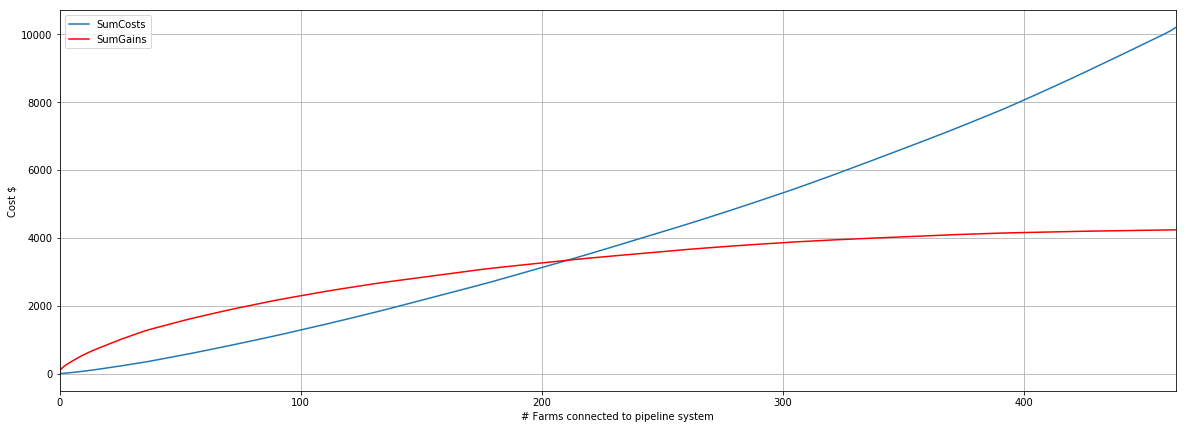

In [17]:
#Convert yield to $
price_of_gas = 0.015
gf2['SumGains'] = gf2['SumYield'] * price_of_gas

ax = gf2['SumCosts'].plot(figsize=(20,7))
gf2['SumGains'].plot(ax=ax,color='red')
ax.set_xlabel("# Farms connected to pipeline system")
ax.set_ylabel("Cost $")
ax.legend()
ax.grid();